In [ ]:
#| default_exp pheno_loader

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from glob import glob
import traceback

import os
import re
from typing import List, Any, Dict, Union
import warnings
import logging

import numpy as np
import pandas as pd

In [ ]:
#| export

from pheno_utils.config import (
    DATASETS_PATH,
    COHORT, 
    EVENTS_DATASET, 
    ERROR_ACTION, 
    BULK_DATA_PATH,
    DICT_PROPERTY_PATH, 
    DATA_CODING_PATH,
    PREFERRED_LANGUAGE
    )
from pheno_utils.basic_analysis import custom_describe
from pheno_utils.bulk_data_loader import get_function_for_field_type
from pheno_utils.questionnaires_handler import transform_dataframe

In [ ]:
#| export

class PhenoLoader:
    """
    Class to load multiple tables from a dataset and allows to easily access
    their fields.

    Args:
    
        dataset (str): The name of the dataset to load.
        base_path (str, optional): The base path where the data is stored. Defaults to DATASETS_PATH.
        cohort (str, optional): The name of the cohort within the dataset. Defaults to COHORT.
        age_sex_dataset (str, optional): The name of the dataset to use for computing age and sex. Defaults to EVENTS_DATASET.
        skip_dfs (list, optional): A list of tables (or substrings that match to tables) to skip when loading the data. Defaults to [].
        unique_index (bool, optional): Whether to ensure the index of the data is unique. Defaults to False.
        valid_dates (bool, optional): Whether to ensure that all timestamps in the data are valid dates. Defaults to False.
        valid_stage (bool, optional): Whether to ensure that all research stages in the data are valid. Defaults to False.
        flexible_field_search (bool, optional): Whether to allow regex field search. Defaults to False.
        keep_undefined_research_stage (bool, optional): Whether to keep samples with undefined research stage. Defaults to False.
        errors (str, optional): Whether to raise an error or issue a warning if missing data is encountered.
            Possible values are 'raise', 'warn' and 'ignore'. Defaults to ERROR_ACTION.

    Attributes:
    
        dict (pd.DataFrame): The data dictionary for the dataset, containing information about each field.
        dfs (dict): A dictionary of dataframes, one for each table in the dataset.
        fields (list): A list of all fields in the dataset.
        dataset (str): The name of the dataset being used.
        cohort (str): The name of the cohort being used.
        base_path (str): The base path where the data is stored.
        dataset_path (str): The full path to the dataset being used.
        age_sex_dataset (str): The name of the dataset being used to compute age and sex.
        skip_dfs (list): A list of tables to skip when loading the data.
        unique_index (bool): Whether to ensure the index of the data is unique.
        valid_dates (bool): Whether to ensure that all timestamps in the data are valid dates.
        valid_stage (bool): Whether to ensure that all research stages in the data are valid.
        flexible_field_search (bool): Whether to allow regex field search.
        keep_undefined_research_stage (bool, optional): Whether to keep samples with undefined research stage.
        errors (str): Whether to raise an error or issue a warning if missing data is encountered.
        preferred_language (str): The preferred language for the questionnaires.
    """

    def __init__(
        self,
        dataset: str,
        base_path: str = DATASETS_PATH,
        cohort: str = COHORT,
        age_sex_dataset: str = EVENTS_DATASET,
        skip_dfs: List[str] = [],
        unique_index: bool = False,
        valid_dates: bool = False,
        valid_stage: bool = False,
        flexible_field_search: bool = False,
        squeeze: bool = False,
        errors: str = ERROR_ACTION,
        read_parquet_kwargs: Dict[str, Any] = {},
        preferred_language: str = PREFERRED_LANGUAGE,
        keep_undefined_research_stage: bool = False
    ) -> None:
        self.dataset = dataset
        self.cohort = cohort
        self.base_path = base_path
        self.dataset_path = self.__get_dataset_path__(self.dataset)
        if self.dataset not in [age_sex_dataset, 'population']:
            self.age_sex_dataset = age_sex_dataset
        else:
            self.age_sex_dataset = None
        self.skip_dfs = skip_dfs
        self.unique_index = unique_index
        self.valid_dates = valid_dates
        self.valid_stage = valid_stage
        self.flexible_field_search = flexible_field_search
        self.squeeze = squeeze
        self.errors = errors
        self.read_parquet_kwargs = read_parquet_kwargs
        self.preferred_language = preferred_language
        self.data_codings = pd.read_csv(DATA_CODING_PATH) # TODO: convert to csv when it will be available
        self.__load_dictionary__()
        self.__load_dataframes__()
        if self.age_sex_dataset is not None:
            self.__load_age_sex__()
        self.dict_prop = pd.read_csv(DICT_PROPERTY_PATH, index_col='field_type')
        self.keep_undefined_research_stage = keep_undefined_research_stage

    def load_sample_data(
        self,
        field_name: Union[str, List[str]],
        participant_id: Union[None, int, List[int]] = None,
        research_stage: Union[None, str, List[str]] = None,
        array_index: Union[None, int, List[int]] = None,
        parent_bulk: Union[None, str] = None,
        load_func: callable = None,
        concat: bool = True,
        pivot=None, 
        keep_undefined_research_stage: Union[None, str] = None,
        **kwargs
    ) -> Union[pd.DataFrame, None]:
        """
        Load time series or bulk data for sample(s).
        Deprecated function. See load_bulk_data().
        """
        warnings.warn('load_sample_data() is deprecated in favour of load_bulk_data() and will be removed in a future version.')
        return self.load_bulk_data(field_name,
                                   participant_id=participant_id,
                                   research_stage=research_stage,
                                   array_index=array_index,
                                   parent_bulk=parent_bulk,
                                   load_func=load_func,
                                   concat=concat,
                                   pivot=pivot,
                                   keep_undefined_research_stage=keep_undefined_research_stage,
                                   **kwargs)

    def load_bulk_data(
        self,
        field_name: Union[str, List[str]],
        participant_id: Union[None, int, List[int]] = None,
        research_stage: Union[None, str, List[str]] = None,
        array_index: Union[None, int, List[int]] = None,
        parent_bulk: Union[None, str] = None,
        load_func: callable = None,
        concat: bool = True,
        pivot=None,
        keep_undefined_research_stage: Union[None, str] = None,
        **kwargs
    ) -> Union[pd.DataFrame, None]:
        """
        Load time series or bulk data for sample(s).

        Args:
            field_name (str or List): The name of the field(s) to load.
            parent_bulk (str, optional): The name of the field that points to the bulk data file. Defaults to None (inferred from field_name).
            participant_id (str or list, optional): The participant ID or IDs to load data for.
            research_stage (str or list, optional): The research stage or stages to load data for.
            array_index (int or list, optional): The array index or indices to load data for.
            load_func (callable, optional): [Deprecated] The function to use to load the data. Defaults to pd.read_parquet
            concat (bool, optional): Whether to concatenate the data into a single DataFrame. Automatically ignored if data is not a DataFrame. Defaults to True.
            pivot (str, optional): The name of the field to pivot the data on (if DataFrame). Defaults to None.
            keep_undefined_research_stage (bool, optional): Whether to keep samples with undefined research stage. Defaults to None.
        """
        if keep_undefined_research_stage is None:
            keep_undefined_research_stage = self.keep_undefined_research_stage
        # get path to bulk file
        if type(field_name) is str:
            field_name = [field_name]
        sample, fields = self.get(field_name + ['participant_id'], return_fields=True, keep_undefined_research_stage=keep_undefined_research_stage)
        fields = [f for f in fields if f != 'participant_id']  # these are fields, as opposed to parent_bulk
        # TODO: slice bulk data based on field_type
        if sample.shape[1] > 2:
            if parent_bulk is not None:
                # get the field_name associated with parent_bulk
                # sample = sample[[parent_bulk, 'participant_id']]
                sample = sample.get([parent_bulk, 'participant_id'], keep_undefined_research_stage=keep_undefined_research_stage)
            else:
                if self.errors == 'raise':
                    raise ValueError(f'More than one field found for {field_name}. Specify parent_bulk')
                elif self.errors == 'warn':
                    warnings.warn(f'More than one field found for {field_name}. Specify parent_bulk')
        col = sample.columns.drop('participant_id')[0]  # can be different from field_name if parent_dataframe is implied
        sample = sample.astype({col: str})

        # filter by participant_id, research_stage and array_index
        query_str = []
        if participant_id is not None:
            query_str.append('participant_id in @participant_id')
            if not isinstance(participant_id, list):
                participant_id = [participant_id]
        if research_stage is not None:
            if not isinstance(research_stage, list):
                research_stage = [research_stage]
            query_str.append('research_stage in @research_stage')
        if array_index is not None:
            if not isinstance(array_index, list):
                array_index = [array_index]
            query_str.append('array_index in @array_index')
        query_str = ' and '.join(query_str)
        if query_str:
            sample = sample.query(query_str)

        # check for missing samples
        if participant_id is not None:
            missing_participants = np.setdiff1d(participant_id, sample['participant_id'].unique())
        else:
            missing_participants = []

        if len(missing_participants):
            if self.errors == 'raise':
                raise ValueError(f'Missing samples: {missing_participants}')
            elif self.errors == 'warn':
                warnings.warn(f'Missing samples: {missing_participants}')
        if len(sample) == 0:
            return None

        # load data
        if load_func is not None:
            warnings.warn("The 'load_func' is deprecated and will be removed in future versions.")
        else: 
            if 'field_type' not in self.dict:
                field_type = None
            else:
                field_type = self.dict.loc[field_name, 'field_type'].values[0]
            load_func = get_function_for_field_type(field_type)
        sample = sample.loc[:, col]
        sample = self.__slice_bulk_partition__(fields, sample)
        kwargs.update(self.__slice_bulk_data__(fields))
        data = []
        for p in sample.unique():
            try:
                data.append(load_func(p, **kwargs))
                if isinstance(data[-1], pd.DataFrame):
                    data[-1] = self.__add_missing_levels__(data[-1], sample.loc[sample == p].to_frame())
                    if query_str:
                        data[-1] = data[-1].query(query_str)
                    data[-1].sort_index(inplace=True)
            except Exception as e:
                if self.errors == 'raise':
                    raise e
                elif self.errors == 'warn':
                    warnings.warn(f'Error loading {p}: {e}')

        # format the final result
        if concat and isinstance(data[0], pd.DataFrame):
            data = pd.concat(data, axis=0)
        if pivot is not None and isinstance(data, pd.DataFrame):
            values = data.columns
            if len(values) == 1:
                values = values[0]
            if pivot in data.index.names:
                data = data.reset_index(pivot)
            data = data.pivot(columns=pivot, values=values)

        return data

    def __repr__(self):
        """
        Return string representation of object

        Returns:
            str: String representation of object
        """
        return self.__str__()

    def __str__(self):
        """
        Return string representation of object

        Returns:
            str: String representation of object
        """
        return f'PhenoLoader for {self.dataset} with' +\
            f'\n{len(self.fields)} fields\n{len(self.dfs)} tables: {list(self.dfs.keys())}'

    def __getitem__(self, fields: Union[str,List[str]]):
        """
        Return data for the specified fields from all tables

        Args:
            fields (Union[str, List[str]]): Fields to return

        Returns:
            pd.DataFrame: Data for the specified fields from all tables
        """
        return self.get(fields)
    
    @staticmethod
    def check_indices_overlap(df1, df2):
        """
        Check whether the indices of two dataframes overlap

        Args:
            df1 (pd.DataFrame): First dataframe
            df2 (pd.DataFrame): Second dataframe

        Returns:
            bool: Whether the indices overlap in more then 1% of the rows
        """
        if df1.empty:
            return True
        if df2.empty:
            return True
        
        df1_defined = df1[df1.index.get_level_values('research_stage') != 'undefined']
        df2_defined = df2[df2.index.get_level_values('research_stage') != 'undefined']
        
        if df1_defined.empty:
            return True
        if df2_defined.empty:
            return True
        
        min_cutoff = 0.01
        
        return df2_defined.index.isin(df1_defined.index).sum() > min(df1_defined.shape[0], df2_defined.shape[0]) * min_cutoff
    
    def build_table_to_field_dict(self, data, fields):
        ''' 
        Build a dictionary of tables to fields of interest.
        '''
        ## pre_check for duplicated columns and overlapping indices
        fields_of_interest_dict = dict()
        for table_name, df in self.dfs.items():
            fields_of_interest = df.columns.intersection(fields)
            if self.check_indices_overlap(data, df[fields_of_interest]): 
                fields_of_interest_dict[table_name] = fields_of_interest
        return fields_of_interest_dict
    
    def get_duplicated_columns(self, table_name, fields_of_interest_dict):
        '''
        Get duplicated fields
        '''
        origin_fields_in_col = fields_of_interest_dict.get(table_name, list())
        duplicated_fields = list()
        for k, v in fields_of_interest_dict.items():
            if k == table_name:
                continue
            if len(v):
                duplicated_fields += set(origin_fields_in_col.intersection(v))
        return duplicated_fields
    
    def rename_duplicated_columns(self, df, table_name, fields, dup_fields):
        '''
        Rename columns in case of duplicated columns
        '''         
        common_dict = {field: f'{table_name}_{field}' for field in dup_fields}
        df = df.rename(columns=common_dict)
        fields += common_dict.values()
        return df, fields
    
    def get_not_found_fields(self, fields, renamed_cols, not_merged, data):
        renamed_fields= np.setdiff1d(fields, renamed_cols)
        only_merged_fields= np.setdiff1d(renamed_fields, not_merged)
        not_found = np.setdiff1d(only_merged_fields, data.columns)
        return not_found
        
    def get(self, fields: Union[str,List[str]], flexible: bool=None, squeeze: bool=None, return_fields: bool=False, keep_undefined_research_stage: bool=None):
        """
        Return data for the specified fields from all tables

        Args:
            fields (List[str]): Fields to return
            flexible (bool, optional): Whether to use fuzzy matching to find fields. Defaults to None, which uses the PhenoLoader's flexible_field_search attribute.
            squeeze (bool, optional): Whether to squeeze the output if only one field is requested. Defaults to None, which uses the PhenoLoader's squeeze attribute.
            return_fields (bool, optional): Whether to return the list of fields that were found. Defaults to False.

        Returns:
            pd.DataFrame: Data for the specified fields from all tables
        """
        if flexible is None:
            flexible = self.flexible_field_search
        if squeeze is None:
            squeeze = self.squeeze
        if keep_undefined_research_stage is None:
            keep_undefined_research_stage = self.keep_undefined_research_stage
        if isinstance(fields, str):
            fields = [fields]

        matches = fields
        if flexible:
            # 1. searching in dictionary, so we can access bulk fields as well as tabular fields
            # 2. keeping the given fields, so we can access fields (e.g., index levels) that are not in the dictionary
            # 3. approximate matches will appear after exact matches
            matches = [self.dict.index[self.dict.index.str.contains(field, case=False)].tolist()
                       for field in fields]
            fields = np.hstack(fields + matches)

        # check whether any field points to a parent_dataframe
        seen_fields = set()
        parent_dict = dict()
        if 'parent_dataframe' in self.dict.columns:
            parent_dict = self.dict.loc[self.dict.index.isin(fields), 'parent_dataframe'].dropna()
        fields = np.hstack([parent_dict.get(field, field) for field in fields])
        fields = [field for field in fields if field not in seen_fields and not seen_fields.add(field)]

        data = pd.DataFrame()
        not_merged = list()
        renamed_cols = list()
        
        fields_of_interest_dict = self.build_table_to_field_dict(data, fields)
        
        for table_name, df in self.dfs.items():
            if 'mapping' in table_name:
                continue
            
            duplicated_fields = self.get_duplicated_columns(table_name, fields_of_interest_dict)
            df, fields = self.rename_duplicated_columns(df, table_name, fields, duplicated_fields)
            
            fields_in_col = df.columns.intersection(fields)
            fields_in_index = np.setdiff1d(np.intersect1d(df.index.names, fields), data.columns)
            
            if len(fields_in_col) or len(fields_in_index):
                if not self.check_indices_overlap(data, df):
                    warnings.warn(f'No overlap between tables, this merge is not recommended. Please view tables separately.\
                        This warning occurred while attempting to add columns from {table_name} to the rest of the data.')
                    
                    not_merged += list(fields_in_col) + list(fields_in_index)
                    continue
            
            index_data_df = pd.DataFrame()
            if len(fields_in_index):
                for field in fields_in_index:
                    index_data_df[field] = df.index.get_level_values(field)
                index_data_df = index_data_df.set_index(df.index)
            
            df_fields = pd.concat([df[fields_in_col], index_data_df], axis=1)
            
            if df_fields.empty:
                continue
            
            if table_name == 'age_sex':
                keep_undefined = True
            else: 
                keep_undefined = keep_undefined_research_stage
                
            data = self.__concat__(
                data, 
                df_fields, 
                keep_undefined
                )
            renamed_cols += duplicated_fields
            
        if len(data):
            data = data.loc[:, ~data.columns.duplicated()]
        
        not_found = self.get_not_found_fields(fields, renamed_cols, not_merged, data)
        if len(not_found) and not flexible:
            if self.errors == 'raise':
                raise KeyError(f'Fields not found: {not_found}')
            elif self.errors == 'warn':
                warnings.warn(f'Fields not found: {not_found}')
        
        data = self.replace_bulk_data_path(data, fields)
        
        cols_order = [field for field in fields if field in data.columns]

        if squeeze and len(cols_order) == 1:
            return data[cols_order[0]]

        if return_fields:
            return data[cols_order], np.unique(np.hstack(matches)).tolist()

        return data[cols_order]
    
    def replace_bulk_data_path(self, data, fields):
        if "item_type" in self.dict.columns:
            # TODO: remove. For now, its backward compatible with old data dictionaries
            bulk_fields = self.dict.loc[self.dict.index.isin(fields)].query('item_type == "Bulk"')
        else: 
            bulk_field_types = self.dict_prop.loc[self.dict_prop.is_bulk == True].index.to_list()
            bulk_fields = self.dict.loc[self.dict.index.isin(fields)].query('field_type in @bulk_field_types')
        cols = [col for col in bulk_fields.index.to_list() if col in data.columns] 
        dataset_bulk_data_path = {k:v.format(dataset=self.dataset) for k, v in BULK_DATA_PATH.items()}
        category_cols = self.dict.loc[self.dict.index.isin(fields)].query('pandas_dtype == "category"').index
    
        for col in category_cols: 
            data[col] = data[col].astype(str)

        data[cols] = data[cols].fillna('nan').replace(dataset_bulk_data_path, regex=True)
        for col in category_cols: 
            data[col] = data[col].astype('category')
            
        return data

    def has_index(self, df, value):
        return value in df.index.names
        
    def is_value_in_index(self, df, value, index_name):
        if self.has_index(df, index_name):
            return value in df.index.get_level_values(index_name)
        return False
    
    @staticmethod
    def join_and_filter_undefined_research_stage(df1, df2):
        df1_defined = df1[df1.index.get_level_values('research_stage') != 'undefined']
        df2_defined = df2[df2.index.get_level_values('research_stage') != 'undefined']

        return df1_defined.join(df2_defined, how='outer')

    def __concat__(self, df1, df2, keep_undefined_research_stage=False):

        if df1.empty:
            return df2
        if df2.empty:
            return df1
        
        if self.is_value_in_index(df1, 'undefined', 'research_stage') and \
            self.is_value_in_index(df2, 'undefined', 'research_stage') and not keep_undefined_research_stage:
        
            warnings.warn('filtering "undefined" research_stage..')
            df = self.join_and_filter_undefined_research_stage(df1, df2)
            return df
        
        return df1.join(df2, how='outer')
        
    def __load_age_sex__(self) -> None:
        """
        Add sex and compute age from birth date.
        """
        age_path = os.path.join(self.__get_dataset_path__(self.age_sex_dataset), 'events.parquet')
        align_df = self.dfs[list(self.dfs)[0]]

        if ('research_stage' in align_df.columns) or ('research_stage' in align_df.index.names):
            try:
                age_df = pd.read_parquet(age_path)
                self.dfs['age_sex'] = align_df.join(
                    age_df[['age_at_research_stage', 'sex']].droplevel('array_index'))\
                    .rename(columns={'age_at_research_stage': 'age'})[['age', 'sex']]

            except Exception as e:
                if self.errors == 'raise':
                    raise(e)
                elif self.errors == 'warn':
                    warnings.warn(f'Error joining research_stage: {e}')
                self.dfs['age_sex'] = pd.DataFrame(index=align_df.index).assign(age=np.nan, sex=np.nan)

        else:
            # init an empty df
            self.dfs['age_sex'] = pd.DataFrame(index=align_df.index).assign(age=np.nan, sex=np.nan)

        self.fields += ['age', 'sex']
        ind = self.dfs['age_sex'].isnull().any(axis=1)
        if not ind.any():  # no missing values
            return

        # fill in missing values by computing age from birth date
        try:
            date_cols = np.array(['collection_date', 'collection_timestamp', 'sequencing_date'])
            date = date_cols[np.isin(date_cols, align_df.columns)][0]  # prefer first match
        except Exception as e:
            if self.errors == 'raise':
                raise(e)
            elif self.errors == 'warn':
                warnings.warn(f'No date field found')
            return

        try:
            ind &= align_df[date].notnull()
        except Exception as e:
            if self.errors == 'raise':
                raise(e)
            if self.errors == 'warn':
                warnings.warn(f'Error checking date field: {e}')
            return
        if not ind.any():
            return

        age_df = pd.read_parquet(age_path.replace('events', 'population'))

        # trying a workaround for a pandas deprecation warning
        age_sex = self.dfs['age_sex']
        try:
            age_df['birth_date'] = pd.to_datetime(
                age_df['year_of_birth'].astype(str) + '-' + age_df['month_of_birth'].astype(str))

            missing_age_sex = align_df.loc[ind, [date]].join(age_df[['sex', 'birth_date']])\
                .assign(age=lambda x: ((x[date] - x['birth_date']).dt.days / 365.25).round(1))\
                [['age', 'sex']]
            age_sex = age_sex.join(missing_age_sex, rsuffix='_miss')

        except Exception as e:
            if self.errors == 'raise':
                print("Exception occurred:\n", traceback.format_exc())
                raise(e)
            elif self.errors == 'warn':
                warnings.warn(f'Error joining on {date}: {e}')

            age_sex = age_sex.join(age_df[['sex']], rsuffix='_miss').assign(age_miss=np.nan)

        age_sex['age'] = age_sex['age'].fillna(age_sex['age_miss'])
        age_sex['sex'] = age_sex['sex'].fillna(age_sex['sex_miss'])
        self.dfs['age_sex'] = age_sex[['age', 'sex']]

    def __load_dataframes__(self) -> None:
        """
        Load all tables in the dataset dictionary.
        """
        self.dfs = {}
        self.fields = set()
        for relative_location in self.dict['relative_location'].dropna().unique():
            parquet_name = relative_location.split(os.sep)[-1]
            internal_location = os.sep.join(relative_location.split(os.sep)[1:])
            
            if any([pattern in relative_location for pattern in self.skip_dfs]):
                
                (f'Skipping {relative_location}')
                continue
            df = self.__load_one_dataframe__(internal_location)
            if df is None:
                continue
            table_name = parquet_name.split('.')[0]
            self.dfs[table_name] = df
            if not df.index.is_unique:
                print('Warning: index is not unique for', table_name)
            self.fields |= set(self.dfs[table_name].columns.tolist())
        self.fields = sorted(list(self.fields))

    def __load_one_dataframe__(self, relative_location: str) -> pd.DataFrame:
        """
        Load one dataframe.

        Args:
            relative_location (str): the location of the dataframe

        Returns:
            pd.DataFrame: the loaded dataframe
        """
    
        df_path = os.path.join(self.dataset_path, relative_location)
        
        try:
            data =  pd.read_parquet(df_path, **self.read_parquet_kwargs)
        except Exception as err:
            if self.errors == 'raise':
                warnings.warn(f'Error loading {df_path}:\n{err}')
                raise err
            if self.errors == 'warn':
                warnings.warn(f'Error loading {df_path}:\n{err}')
            return None
        
        data = transform_dataframe(data, transform_from='coding', transform_to=self.preferred_language, 
                                   dict_df=self.dict, mapping_df=self.data_codings)
            
        # set the order of columns according to the dictionary
        dict_columns = self.dict.index.intersection(data.columns)
        other_columns = data.columns.difference(self.dict.index)
        assert (len(dict_columns) + len(other_columns)) == len(data.columns), "something isn't right"
        data = data[dict_columns.tolist() + other_columns.tolist()]

        before = len(data)
        if self.unique_index:
            data = data.loc[~data.index.duplicated()]
        if self.valid_dates:
            data = data.loc[data.select_dtypes(include=['datetime64[ns]']).notnull().any(axis=1)]
        if self.valid_stage:
            data = data.loc[data.index.get_level_values('research_stage').notnull()]
        after = len(data)
        if before > after:
            print(f'Filtered {before - after} rows')

        return data

    def __load_dictionary__(self) -> None:
        """
        Load dataset dictionary.
        """
        self.dict = pd.read_csv(self.__get_dictionary_file_path__(self.dataset))\
            .dropna(subset='tabular_field_name')\
            .set_index('tabular_field_name')

        if 'bulk_dictionary' not in self.dict.columns or len(self.dict.dropna(subset='bulk_dictionary')['bulk_dictionary']) == 0:
            return

        # bulk dictionaries
        bulk_dicts = self.dataset_path + '/metadata/' + \
            self.dict.dropna(subset='bulk_dictionary')['bulk_dictionary'] + '_bulk_dictionary.csv'
        self.dict = pd.concat([self.dict] +
            [pd.read_csv(bd).set_index('tabular_field_name').assign(parent_dataframe=tfn)
             for tfn, bd in bulk_dicts.items()], axis=0)

    def __get_file_path__(self, dataset: str, extension: str) -> str:
        """
        Get the file path for a dataset and an extension.

        Args:
            dataset (str): the name of the dataset
            extension (str): the extension of the file

        Returns:
            str: the path to the file
        """
        path = os.path.join(self.dataset_path, '*.' + extension)
        if path.startswith('s3://'):
           return path
        return glob(path)[0]

    def __get_dictionary_file_path__(self, dataset: str) -> str:
        """
        Get the file path for data dictionary.

        Args:
            dataset (str): the name of the dataset

        Returns:
            str: the path to the file
        """
        path = os.path.join(self.dataset_path, 'metadata', f'{dataset}_data_dictionary.csv')
        if path.startswith('s3://'):
           return path
        return glob(path)[0]
    
    def __get_dataset_path__(self, dataset):
        """
        Get the dataset path.
        
        Args:
            dataset (str): the name of the dataset

        Returns:
            str: the path to the dataset
        """
        if self.cohort is not None:
            return os.path.join(self.base_path, dataset, self.cohort)
        return os.path.join(self.base_path, dataset)

    def __add_missing_levels__(self, data: pd.DataFrame, more_levels: pd.DataFrame) -> pd.DataFrame:
        """
        Extends the index levels of the given DataFrame ('data') by appending missing levels
        found in another DataFrame ('more_levels').

        This method performs a left join on the common index levels between 'data' and 'more_levels'.
        The extra index level from 'more_levels' is appended at the end of the index levels in 'data'.
        Rows present in 'data' are retained, and their indices are potentially extended.
        Rows from 'more_levels' that do not exist in 'data' are not included in the output.

        Parameters:
        -----------
        data : pd.DataFrame
            The DataFrame whose index levels you want to extend.
            This DataFrame's rows will all be present in the output DataFrame.

        more_levels : pd.DataFrame
            The DataFrame used as a reference for adding extra index levels to 'data'.

        Returns:
        --------
        pd.DataFrame
            A new DataFrame with the same rows as 'data' but potentially extended index levels.

        Example:
        --------
        # Given the following DataFrames:
        data: index(levels: A, B), columns: [value]
        more_levels: index(levels: A, B, C), columns: [value]

        # The output will have:
        index(levels: A, B, C), columns: [value]
        """
        # Identify common index levels
        common_index_levels = list(set(data.index.names).intersection(set(more_levels.index.names)))
        if len(common_index_levels) == 0:
            return data
        
        # Identify the extra index level in more_levels
        extra_index_levels = [l for l in more_levels.index.names if l not in common_index_levels]
        
        if not extra_index_levels:
            # If there are no additional index levels in more_levels, return data as is
            return data

        # Reset the index of more_levels to convert all index levels to columns
        more_levels_reset = more_levels.reset_index()
        
        # Select only the common and extra index levels
        more_levels_subset = more_levels_reset[common_index_levels + extra_index_levels].drop_duplicates()
        
        # Merge the dataframes on the common index levels using a left join
        new_data = pd.merge(data.reset_index(), more_levels_subset, how='left', on=common_index_levels)
        
        # Explicitly set the order of the new index levels to maintain
        # the original order in 'more_levels' and append the extra remaining levels
        new_index_order = more_levels.index.names + \
            [l for l in data.index.names if l not in more_levels.index.names]
        
        new_data.set_index(new_index_order, inplace=True)
        
        return new_data

    def __slice_bulk_partition__(self, field_name: str, paths: pd.Series) -> pd.Series:
        """
        Slice the bulk partition based on the field name.

        Args:
            field_name (str): The name of the field.
            paths (pd.Series): The paths to be sliced.

        Returns:
            pd.Series: The sliced paths.
        """
        if 'field_type' not in self.dict:
            return paths

        partition = self.dict.loc[field_name, 'field_type']
        if isinstance(partition, pd.Series):
            partition = partition.iloc[0]
        if type(partition) is not str:
            return paths
        if 'partition' not in partition:
            return paths
        partition = partition.split(':')[1].strip()

        paths[paths.str[-1] != '/'] += '/'
        paths += partition + '=' + field_name + '/'
        return paths

    def __slice_bulk_data__(self, field_name: str) -> dict:
        """
        Generate keyword arguments for pd.read_parquet based on the field name.

        Args:
            field_name (str): The name of the field.

        Returns:
            dict: The keyword arguments for pd.read_parquet.
        """
        if 'field_type' not in self.dict:
            return {}

        slice_by = self.dict.loc[field_name, 'field_type']
        if type(field_name) is str:
            field_name = [field_name]
        if isinstance(slice_by, pd.Series):
            # get all fields that have the same field_type (first type)
            field_name = slice_by[slice_by == slice_by.iloc[0]].index.tolist()
            slice_by = slice_by.iloc[0]
        if type(slice_by) is not str:
            return {}
        if 'column' in slice_by:
            return {'columns': field_name}
        if 'rows' in slice_by:
            return {'filters': [[(slice_by.split(':')[1].strip(), '==', f)] for f in field_name],
                    'engine': 'pyarrow'}
        return {}

    def describe_field(self, fields: Union[str,List[str]], return_summary: bool=False):
        """
        Display a summary dataframe for the specified fields from all tables

        Args:
            fields (List[str]): Fields to return
            return_summary (Bool): whether to return the summary dataframe
        
        Returns:
            pd.DataFrame: Data for the specified fields from all tables
        """
        if isinstance(fields, str):
            fields = [fields]
        
        summary_df = pd.concat([self.dict.loc[fields,:].T,
                                custom_describe(self[fields])])
        display(summary_df)
        if return_summary:
            return summary_df

Use the dataset name to load the dataset. It may contain multiple tables. Age / sex will be added to the data by default. The default `base_path` is set to work on the research platform.

In [ ]:
pl = PhenoLoader('fundus', errors='warn')
pl

PhenoLoader for fundus with
78 fields
2 tables: ['fundus', 'age_sex']

The PhenoLoader class contains several usefull attributes

The data dictionary of the dataset displays the description of each field.

In [ ]:
pl.dict.head(3)

field_string  \
tabular_field_name                                 
fundus_image_left            Fundus image (left)   
fundus_image_right          Fundus image (right)   
collection_date     Collection date (YYYY-MM-DD)   

                              description_string  parent_dataframe  \
tabular_field_name                                                   
fundus_image_left            Fundus image (left)               NaN   
fundus_image_right          Fundus image (right)               NaN   
collection_date     Collection date (YYYY-MM-DD)               NaN   

                        relative_location value_type units  sampling_rate  \
tabular_field_name                                                          
fundus_image_left   fundus/fundus.parquet      Text    NaN            NaN   
fundus_image_right  fundus/fundus.parquet      Text    NaN            NaN   
collection_date     fundus/fundus.parquet       Date  Time            NaN   

                                 field_type   array cohorts data_type  \
tabular_field_name                                                      
fundus_image_left   Image file (individual)  Single     10K     image   
fundus_image_right  Image file (individual)  Single     10K     image   
collection_date                        Data  Single     10K   tabular   

                         debut    pandas_dtype  
tabular_field_name                              
fundus_image_left   2021-02-17          string  
fundus_image_right  2021-02-17          string  
collection_date     2021-02-17  datetime64[ns]

In [ ]:
pl.dfs.keys()

dict_keys(['fundus', 'age_sex'])

In [ ]:
import pandas as pd

# Example DataFrame with MultiIndex
data = {
    'value': [10, 20, 30, 40]
}
tuples = [('A', 'x'), ('A', 'y'), ('B', 'x'), ('B', 'y')]
index = pd.MultiIndex.from_tuples(tuples, names=['outer', 'inner'])
df = pd.DataFrame(data, index=index)

# Reset the index
df_reset = df.reset_index()

# Re-add the desired index levels ('outer', 'inner' in this case) as index
df_final = df_reset.set_index(['outer', 'inner'])

In [ ]:
pl.dfs['fundus'].head(3)

fundus_image_left  \
participant_id cohort research_stage array_index                     
0              10k    00_00_visit    0               /path/to/file   
1              10k    00_00_visit    0               /path/to/file   
2              10k    00_00_visit    0               /path/to/file   

                                                 fundus_image_right  \
participant_id cohort research_stage array_index                      
0              10k    00_00_visit    0                /path/to/file   
1              10k    00_00_visit    0                /path/to/file   
2              10k    00_00_visit    0                /path/to/file   

                                                 collection_date  \
participant_id cohort research_stage array_index                   
0              10k    00_00_visit    0                2022-11-16   
1              10k    00_00_visit    0                2022-06-30   
2              10k    00_00_visit    0                2021-10-05   

                                                  fractal_dimension_left  \
participant_id cohort research_stage array_index                           
0              10k    00_00_visit    0                          1.564989   
1              10k    00_00_visit    0                          1.542311   
2              10k    00_00_visit    0                          1.482051   

                                                  fractal_dimension_right  \
participant_id cohort research_stage array_index                            
0              10k    00_00_visit    0                           1.520885   
1              10k    00_00_visit    0                           1.534158   
2              10k    00_00_visit    0                           1.545097   

                                                  artery_average_width_left  \
participant_id cohort research_stage array_index                              
0              10k    00_00_visit    0                         18430.284751   
1              10k    00_00_visit    0                         17315.398780   
2              10k    00_00_visit    0                         15375.866993   

                                                  artery_average_width_right  \
participant_id cohort research_stage array_index                               
0              10k    00_00_visit    0                          19038.547771   
1              10k    00_00_visit    0                          19099.489575   
2              10k    00_00_visit    0                          19855.576862   

                                                  artery_distance_tortuosity_left  \
participant_id cohort research_stage array_index                                    
0              10k    00_00_visit    0                                   3.668175   
1              10k    00_00_visit    0                                   2.095461   
2              10k    00_00_visit    0                                   2.776472   

                                                  artery_distance_tortuosity_right  \
participant_id cohort research_stage array_index                                     
0              10k    00_00_visit    0                                    3.271147   
1              10k    00_00_visit    0                                    1.634782   
2              10k    00_00_visit    0                                    2.747015   

                                                  artery_fractal_dimension_left  \
participant_id cohort research_stage array_index                                  
0              10k    00_00_visit    0                                 1.355673   
1              10k    00_00_visit    0                                 1.368933   
2              10k    00_00_visit    0                                 1.360404   

                                                  ...  \
participant_id cohort research_stage array_index  ...   
0              10k    00_00_visit    0            

All availbale fields (columns) in all tables can be listed.

In [ ]:
pl.fields[:5]

['artery_average_width_left',
 'artery_average_width_right',
 'artery_distance_tortuosity_left',
 'artery_distance_tortuosity_right',
 'artery_fractal_dimension_left']

In [ ]:
pl['vein_average_width_right']

vein_average_width_right
participant_id cohort research_stage array_index                          
0              10k    00_00_visit    0                        18436.428634
1              10k    00_00_visit    0                        18888.160314
2              10k    00_00_visit    0                        19013.865043
3              10k    00_00_visit    0                        18809.012493
4              10k    00_00_visit    0                        19428.986690

Access any of the fields (e.g., `vein_average_width_right`, `age`) or indices (e.g., `research_stage`) from any of the tables via the data loader API.

In [ ]:
pl[['research_stage', 'vein_average_width_right', 'age', 'sex']]

research_stage  \
participant_id cohort research_stage array_index                  
0              10k    00_00_visit    0              00_00_visit   
1              10k    00_00_visit    0              00_00_visit   
2              10k    00_00_visit    0              00_00_visit   
3              10k    00_00_visit    0              00_00_visit   
4              10k    00_00_visit    0              00_00_visit   

                                                  vein_average_width_right  \
participant_id cohort research_stage array_index                             
0              10k    00_00_visit    0                        18436.428634   
1              10k    00_00_visit    0                        18888.160314   
2              10k    00_00_visit    0                        19013.865043   
3              10k    00_00_visit    0                        18809.012493   
4              10k    00_00_visit    0                        19428.986690   

                                                   age  sex  
participant_id cohort research_stage array_index             
0              10k    00_00_visit    0            43.5    0  
1              10k    00_00_visit    0            53.7    1  
2              10k    00_00_visit    0            26.2    0  
3              10k    00_00_visit    0            44.6    1  
4              10k    00_00_visit    0            50.3    0

Access time series or bulk data that is stored separately for each sample via the data loader API. In the following example, the data loader retrieves the relative path of each sample's bulk file from the main table (where it is stored in the field `fundus_image_left`), converts it to an absolute path, and loads the file. This is repeated for 2 samples and returned as a list. In the case of parquet DataFrames, there is no need to define the `load_func` and multiple DFs are concatenated by deafult.

In [ ]:
pl.dfs['fundus']['fundus_image_left']

participant_id  cohort  research_stage  array_index
0               10k     00_00_visit     0              /path/to/file
1               10k     00_00_visit     0              /path/to/file
2               10k     00_00_visit     0              /path/to/file
3               10k     00_00_visit     0              /path/to/file
4               10k     00_00_visit     0              /path/to/file
Name: fundus_image_left, dtype: object

In [ ]:
#| hide

pl.dfs['fundus']['fundus_image_left'] = [f'M0/images/fundus_{i}.png' for i in range(5)]

[None, None]

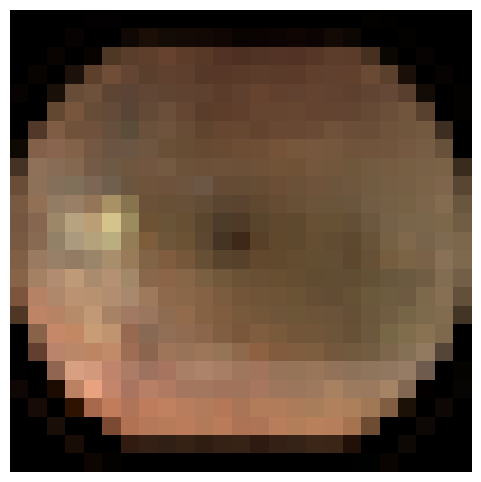

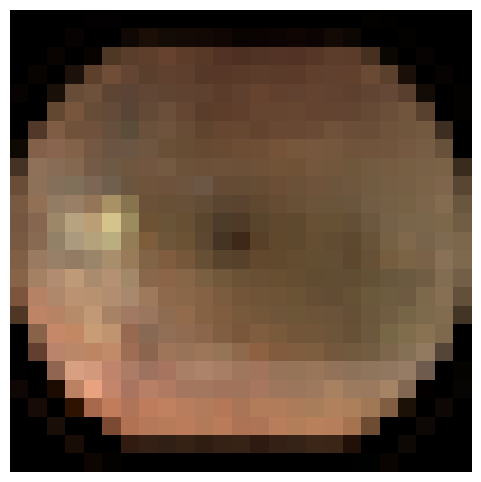

In [ ]:
pl.load_bulk_data('fundus_image_left', participant_id=[0, 1])

You can perform flexible field search (with regex support), when initializing the PhenoLoader as follows:

In [ ]:
pl = PhenoLoader('fundus', flexible_field_search=True)

For example, the following command will search for any field starting with "fractal".

In [ ]:
pl['^fractal']

fractal_dimension_left  \
participant_id cohort research_stage array_index                           
0              10k    00_00_visit    0                          1.564989   
1              10k    00_00_visit    0                          1.542311   
2              10k    00_00_visit    0                          1.482051   
3              10k    00_00_visit    0                          1.548773   
4              10k    00_00_visit    0                          1.554922   

                                                  fractal_dimension_right  
participant_id cohort research_stage array_index                           
0              10k    00_00_visit    0                           1.520885  
1              10k    00_00_visit    0                           1.534158  
2              10k    00_00_visit    0                           1.545097  
3              10k    00_00_visit    0                           1.539352  
4              10k    00_00_visit    0                           1.557029

You can summarize a field or set of fields by the following command

In [ ]:
pl.describe_field(['fundus_image_right', 'collection_date'])

fundus_image_right               collection_date
field_string           Fundus image (right)  Collection date (YYYY-MM-DD)
description_string     Fundus image (right)  Collection date (YYYY-MM-DD)
parent_dataframe                        NaN                           NaN
relative_location     fundus/fundus.parquet         fundus/fundus.parquet
value_type                            Text                           Date
units                                   NaN                          Time
sampling_rate                           NaN                           NaN
field_type          Image file (individual)                          Data
array                                Single                        Single
cohorts                                 10K                           10K
data_type                             image                       tabular
debut                            2021-02-17                    2021-02-17
pandas_dtype                         string                datetime64[ns]
count                                     5                             5
unique                                    1                             5
most_frequent                 /path/to/file                           NaN
min                                     NaN           2021-10-05 00:00:00
max                                     NaN           2022-11-16 00:00:00
mean                                    NaN                           NaN
median                                  NaN                           NaN
std                                     NaN                           NaN

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()